<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Adapters in PyTorch**

Estimated time needed: **45** minutes

**_Note to advanced users_: If you are already familiar with classical fine-tuning and you only want to see the section that relates to adapters, skip forward to <a href="#Adapters">Adapters</a> and run all of the cells above that section by going to _Run --> Run All Above Selected Cell_**

You can fine-tune a neural network in several ways. Common strategies include adjusting only the final layer or fine-tuning all layers. However, these methods have their drawbacks: fine-tuning just the final layer often leads to less than optimal results, while fine-tuning all layers can be very time-consuming.

To address these issues, researchers have developed various parameter efficient fine-tuning (PEFT) techniques. One such technique involves the use of adapters. Adapters enable modular training, where small, task-specific modules are trained within the model without changing the pre-existing pretrained parameters. This approach efficiently tailors the model to new tasks with a reduced risk of overfitting. However, adapters are not a cure-all solution. While they are less likely to overfit and are computationally efficient, they might not always reach the same level of accuracy as full model fine-tuning, particularly if the task necessitates substantial changes from the pretrained model's original capabilities.

In this hands-on lab, you learn how to apply an adapter to a transformer-based neural network that has been trained on the AG News data set, with the aim of using this model on the IMDB data set. You also evaluate and compare the performance of this method with that of a fully fine-tuned model and a model where only the last layer is fine-tuned.



# __Table of contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Install-required-libraries">Install required libraries</a></li>
            <li><a href="#Import-required-libraries">Import required libraries</a></li>
            <li><a href="#Define-helper-functions">Defining helper functions</a></li>
        </ol>
    </li>
    <li><a href="#Positional-encodings">Positional encodings</a></li>
    <li><a href="#Import-IMDB-dataset">Import IMDB data set</a></li>
    <ol>
        <li><a href="#IMDB-dataset-overview">IMDB data set overview</a></li>
        <ol>
            <li><a href="#Dataset-composition">Data set composition</a></li>
            <li><a href="#Applications">Applications</a></li>
            <li><a href="#Challenges">Challenges</a></li>
            <li><a href="#Dataset-splits">Data set splits</a></li>
            <li><a href="#Data-loader">Data loader</a></li>
            <li><a href="#Neural-network">Neural network</a></li>
        </ol>
    </ol>
    <li>
        <a href="#Training">Training</a>
        <ol>
            <li><a href="#Train-IMDB">Train IMDB</a></li>
            <li><a href="#Fine-tune-a-model-pretrained-on-the-AG-News-dataset">Fine-tune a model pretrained on the AG News data set</a></li>
            <li><a href="#Fine-tune-the-final-layer-only">Fine-tune the final layer only</a></li>
        </ol>
    </li>
    <li>
        <a href="#Adapters">Adapters</a>
        <ol>
            <li><a href="#Benefits-of-using-adapters-in-neural-networks">Benefits of using adapters in neural networks</a></li>
        </ol>
    </li>
    <li>
        <a href="#Exercise:-Adapt-linear-layers-in-a-different-network">Exercise: Adapt linear layers in a different network</a>
    </li>
</ol>


---


# Objectives

After completing this lab, you are able to:

- Define and pretrain a transformer-based neural network using PyTorch for a classification task [Optional]
- Fully fine-tune the pretrained model for a different classification task [Optional]
- Compare results by fine-tuning only the last layer of the pretrained model [Optional]
- Understand how adapters work
- Apply adapters to linear layers in a neural network
- Train a neural network in a parameter efficient way by training just the adapted layers



---


# Setup


### Install required libraries


For this lab, you use the following libraries, which are __not__ preinstalled in the Skills Network Labs environment. __You must run the code in the following cell__ to install them.


In [ ]:
!pip install torch==2.2.2
!pip install torchtext==0.17.2
!pip install portalocker==2.8.2
!pip install torchdata==0.7.1
!pip install plotly==5.22.0
!pip install pandas
!pip install matplotlib==3.9.0 scikit-learn==1.5.0

In [ ]:
!pip install numpy==1.26.0

### Import required libraries

The following code imports the required libraries.


In [2]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
torch.set_num_threads(1)
from torch import nn
import os


from torch.utils.data import DataLoader

from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, Vectors
from torchtext.datasets import IMDB
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import pickle

from urllib.request import urlopen
import io

import tarfile
import tempfile

from torch.nn.utils.rnn import pad_sequence

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Define helper functions

The following code shows some helper functions to help with plotting, saving, and loading files. These functions are not the main focus of this lab, so you do not have to dwell on these too long. However, do run the cells in this section to define these helper functions.


In [3]:
def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [4]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

---


# Positional encodings

Positional encodings play a pivotal role in transformers and various sequence-to-sequence models, aiding in conveying critical information regarding the positions or sequencing of elements within a given sequence. To illustrate, let's examine the sentences: "He painted the car red" and "He painted the red car." Despite their distinct meanings, it's worth noting that the embeddings for these sentences remain identical in the absence of positional encodings. The following class defines positional encodings by inheriting from PyTorch's `Module` class.


In [5]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

# Import IMDB data set


The following code loads the IMDB data set.


In [6]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

## IMDB data set overview

The **IMDB data set** contains movie reviews from the Internet Movie Database (IMDB) and is commonly used for binary sentiment classification tasks. It's a popular data set for training and testing models in natural language processing (NLP), particularly in the context of sentiment analysis.

### Data set composition

- **Reviews**: The data set consists of 50,000 movie reviews, divided evenly into 25,000 training and 25,000 testing samples.
- **Sentiment labels**: Each review is labeled as either positive or negative, indicating the sentiment expressed in the review. The data set is balanced, with an equal number of positive and negative reviews in both the training and testing sets.
- **Text content**: Reviews are presented as plain text and have been preprocessed to some extent. For example, HTML tags are removed, but the text retains its original punctuation and capitalization.
- **Usage**: The data set is commonly used to train models for binary sentiment classification, where the goal is to predict whether a given review is positive or negative based on its text content.

### Applications

- **Sentiment analysis**: The primary application of the IMDB data set is in sentiment analysis, where it serves as a benchmark for various text classification algorithms.
- **Natural language processing**: The data set is widely used in NLP research and applications, providing a basis for testing the effectiveness of different models and approaches in understanding human language.

### Challenges

The data set is small, so it's hard to train a model from scratch.

The following class is defined to traverse the IMDB data set. The need to define this class arises from the fact that the IMDB data set is split across a large number of files.


In [7]:
class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return label, content

The following code uses the `IMDBDataset` class previously defined to create iterators for the train and test data sets. In the latter part of the cell, you can return 20 examples from the train set.


In [8]:
root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test data

start=train_iter.pos_inx
for i in range(-10,10):
    print(train_iter[start+i])

(0, "Yeti: Curse of the Snow Demon starts aboard a plane full of American high school teens who are on their way to play a football game in Japan, unfortunately during a fierce thunder storm their plane crashes in the Himalayas. Unlucky really. With some dead & some alive the survivors have to think about themselves & decide to wait it out until help comes. However just when they think their luck couldn't get any worse they soon discover that a huge, hairy Yeti type Abominable Snowman creature wants to kill & eat them all. Trapped, cold, starving & fighting for survival will help reach the stranded teens in time?<br /><br />Yeah, with a title like Yeti: Curse of the Snow Demon it can only mean one thing & that is that someone at the Sci-Fi Channel has made yet another 'Creature Feature' although to give these things a bit of variety the Sci-Fi Channel here in the UK are now dubbing them as a 'Beast Feast'! As if that will make any difference. Directed by Paul Ziller one has to say that

The following code defines the mapping of numeric labels to positive and negative reviews.


In [9]:
imdb_label = {0: " negative review", 1: "positive review"}
imdb_label[1]

'positive review'

The following code checks to ensure that there are exactly two classes in the train data set.


In [10]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

The following code loads a basic English tokenizer and defines a function called ```yield_tokens``` that uses the tokenizer to break down text data yielded by an iterator into tokens.


In [11]:
tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    """Yield tokens for each data sample."""
    for _, text in data_iter:
        yield tokenizer(text)

 The following code loads a pretrained word embedding model called GloVe into a variable called `glove_embedding`.


In [12]:
# Note that GloVe embeddings are typically downloaded using:
#glove_embedding = GloVe(name="6B", dim=100)
# However, the GloVe server is frequently down. The code below offers a workaround


class GloVe_override(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        #name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override, self).__init__(name, url=url, **kwargs)

class GloVe_override2(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        #name = "glove.{}.{}d.txt".format(name, str(dim))
        name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override2, self).__init__(name, url=url, **kwargs)

try:
    glove_embedding = GloVe_override(name="6B", dim=100)
except:
    try:
        glove_embedding = GloVe_override2(name="6B", dim=100)
    except:
        glove_embedding = GloVe(name="6B", dim=100)

The following code builds a vocabulary object from a pretrained GloVe word embedding model and sets the default index to the <unk> token.


In [13]:
from torchtext.vocab import GloVe,vocab
# Build vocab from glove_vectors
vocab = vocab(glove_embedding .stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

Let's count the number of words in the vocab:


In [14]:
vocab_size=len(vocab)
vocab_size

400002

Let's test the ```vocab``` function:


In [15]:
vocab(['he'])

[20]

### Data set splits


The following converts the data set into map-style data sets and then performs a random split to create separate training and validation data sets. The training data set will contain 95% of the samples in the original training set, while the validation data set will contain the remaining 5%. These data sets can be used for training and evaluating a machine learning model for text classification on the IMDB data set. The final performance of the model will be evaluated on the hold-out test set.


In [16]:
# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

Be aware that the Skills Network currently does not offer GPU access to learners. As a result, training on the full data set could be time-consuming. To address this, you further reduce the size of the training set. This approach helps you mimic the training process as if a GPU were available. However, if you want to train using the full IMDB data set, you must either comment out or remove the two lines in the following code block.


In [17]:
num_train = int(len(train_dataset) * 0.05)
split_train_, _ = random_split(split_train_, [num_train, len(split_train_) - num_train])

The following code checks to see if a CUDA-compatible GPU is available in the system using PyTorch, a popular deep learning framework. If a GPU is available, it assigns the device variable to "cuda" (which stands for CUDA, the parallel computing platform and application programming interface model developed by NVIDIA). If a GPU is not available, it assigns the device variable to "cpu" (which means the code will run on the CPU instead).


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader


The following code prepares the text processing pipeline with the tokenizer and vocabulary. The text pipeline is used to process the raw data strings from the data set iterators.

The function **```text_pipeline```** first tokenizes the input text, then **```vocab```** is applied to get the token indices.


In [19]:
def text_pipeline(x):
    return vocab(tokenizer(x))

In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a `collate_batch` function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the `text_pipeline` function to preprocess the text. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (for example, GPU) for efficient computation.


In [20]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:

        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

You can convert the data set objects to data loaders by applying the `collate` function.


In [21]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

Let's check to see what these data loaders generate.


In [22]:
label,seqence=next(iter(valid_dataloader))
label,seqence

(tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
         0, 0, 0, 1, 1, 0, 1, 0]),
 tensor([[  83,  348, 3747,  ...,    0,    0,    0],
         [  39,  283, 2146,  ...,    0,    0,    0],
         [  39,   16,  122,  ...,    0,    0,    0],
         ...,
         [  43,   35,   38,  ...,    0,    0,    0],
         [ 153,   85,   83,  ...,    0,    0,    0],
         [   2,  350,  321,  ...,    0,    0,    0]]))

### Neural network


This code defines a class called Net that represents a text classifier based on a PyTorch TransformerEncoder.
The constructor takes the following arguments:

- `num_class`: The number of classes to classify
- `vocab_size`: The size of the vocabulary
- `freeze`: Whether to freeze the embedding layer
- `nhead`: The number of heads in the transformer encoder
- `dim_feedforward`: The dimension of the feedforward layer in the transformer encoder
- `num_layers`: The number of transformer encoder layers
- `dropout`: The dropout rate
- `activation`: The activation function to use in the transformer encoder
- `classifier_dropout`: The dropout rate for the classifier

**Attributes:**

- `emb`: An embedding layer that maps each word in the vocabulary to a dense vector representation
- `pos_encoder`: A positional encoding layer that adds positional information to the word vectors
- `transformer_encoder`: A transformer encoder layer that processes the sequence of word vectors and extracts high-level features
- `classifier`: A linear layer that maps the output of the transformer encoder to the desired number of classes

---




In [23]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """
    def __init__(

        self,
        num_class,vocab_size,
        freeze=True,
        nhead=2,
        dim_feedforward=128,
        num_layers=2,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        #self.emb = embedding=nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        self.emb = nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        embedding_dim = self.emb.embedding_dim


        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

The model can then be trained on labeled data from the IMDB data set with two classes.


Let's create the model.


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_class=2,vocab_size=vocab_size).to(device)
model

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)

The following **`predict`** function takes in a text, a text pipeline, and a model as inputs. It uses a pretrained model passed as a parameter to predict the label of the text for text classification on the IMDB data set.


In [25]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [26]:
predict("I like sports and stuff", text_pipeline, model)

' negative review'

You can create a function to evaluate the model's accuracy on a data set. Here, you define two nearly identical evaluation functions, one that provides a `tqdm` progress bar, and one that does not.


In [27]:
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in tqdm(dataloader):
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [28]:
def evaluate_no_tqdm(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

The following code evaluates the performance of your model. Note that this can take approximately 4 minutes on a CPU. **For efficiency, let's not run this cell now, but trust us that the performance of the untrained model is no better than average. If you wish to confirm yourself of this fact, you are free to uncomment this cell**:


In [29]:
evaluate(test_dataloader, model)

100%|██████████| 782/782 [10:58<00:00,  1.19it/s]


0.5

Note that the current performance of the model is no better than average. This outcome is expected, considering that the model has not undergone any training yet.


---


# Training


The following coe defines the training function used to train your model.


In [30]:
def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        #print(model)
        #for parm in model.parameters():
        #    print(parm.requires_grad)
        
        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            #print(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate_no_tqdm(valid_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                pass
                #print("save model epoch",epoch)
                #torch.save(model.state_dict(), model_path)
                #save_list_to_file(lst=acc_epoch, filename=acc_dir)
                #save_list_to_file(lst=cum_loss_list, filename=loss_dir)

    time_end = time.time()
    print(f"Training time: {time_end - time_start}")

### Train IMDB

The following code sets the learning rate (LR) to 1, which determines the step size at which the optimizer updates the model's parameters during training. The CrossEntropyLoss criterion is used to calculate the loss between the model's predicted outputs and the ground truth labels. This loss function is commonly employed for multiclass classification tasks.

The chosen optimizer is Stochastic Gradient Descent (SGD), which optimizes the model's parameters based on the computed gradients with respect to the loss function. The SGD optimizer uses the specified learning rate to control the size of the weight updates.

Additionally, a learning rate scheduler is defined using StepLR. This scheduler adjusts the learning rate during training, reducing it by a factor (gamma) of 0.1 after every epoch (step) to improve convergence and fine-tune the model's performance. These components together form the essential setup for training a neural network using the specified learning rate, loss criterion, optimizer, and learning rate scheduler.

For the sake of time efficiency, **the following lines are commented out and the model is not actually trained**. If you would like to get a glimpse of what training would look like, uncomment the following code block to train the model for 2 epochs. If you were to train this model in a real-world scenario, you would likely increase the number of epochs to a larger figure, such as 100 or more. Given the reduced training set defined earlier, it takes approximately 2 minutes to complete 2 epochs of training.


In [31]:

LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_IMDB dataset small2.pth"
train_model(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=train_dataloader, 
            valid_dataloader=valid_dataloader, 
            epochs=2, 
            save_dir=save_dir, 
            file_name=file_name
           )


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 31.361206650733948


 50%|█████     | 1/2 [01:00<01:00, 60.41s/it]

0.4728
Epoch 2/2 - Loss: 30.63384222984314


100%|██████████| 2/2 [01:54<00:00, 57.10s/it]

0.5272
Training time: 114.20317435264587


Let's load a model that has been pretrained using the same method but on the full data set and with 100 epochs.

The following code plots the cost and validation data accuracy for each epoch of the pretrained model up to and including the epoch that yielded the highest accuracy. As you can see, the pretrained model achieved an accuracy of over 85% on the validation set.


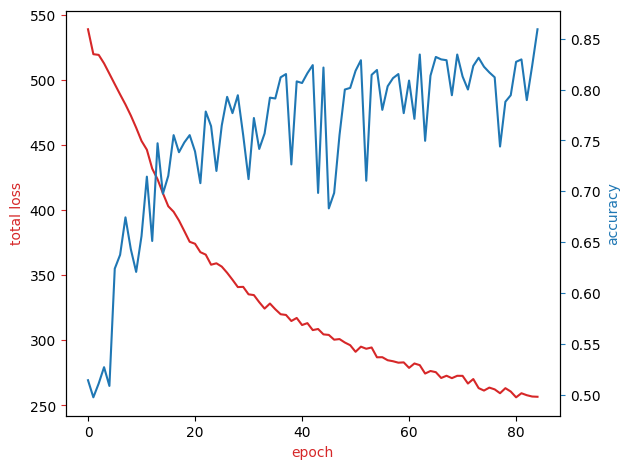

In [32]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/sybqacL5p1qeEO8d4xRZNg/model-IMDB%20dataset%20small2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/eOt6woGoaOB565T0RLH5WA/model-IMDB%20dataset%20small2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following code loads your pretrained model and evaluates its performance on the test set. **For efficiency, let's not run the evaluation because it can take approximately 4 minutes to run. Instead, report the result underneath the cell. If you would like to confirm the result for yourself, you are free to uncomment the last line in the following code block.**


In [33]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/q66IH6a7lglkZ4haM6hB1w/model-IMDB%20dataset%20small2.pth')
model_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_)

100%|██████████| 782/782 [09:36<00:00,  1.36it/s]


0.83172

As you can see, the pretrained model achieved an accuracy of approximately 83% on the test data.


### Fine-tune a model pretrained on the AG News data set

Rather than training a model on the IMDB data set as you did earlier, you can fine-tune a model that has been pretrained on the AG News data set, which is a collection of news articles. The goal of the AG News data set is to categorize news articles into one of four categories: Sports, Business, Sci/tech, or World. You’ll start training a model from scratch on the AG News data set. To save time, you can do this in just one cell. Also, for efficiency, ** comment out the training bit**. If you want to train the model for 2 epochs on a smaller data set to demonstrate what the training process would look like, uncomment the part that says `### Uncomment to Train ###` before running the cell. Training for 2 epochs on the reduced data set can take approximately 3 minutes.


In [34]:
train_iter_ag_news = AG_NEWS(split="train")

num_class_ag_news = len(set([label for (label, text) in train_iter_ag_news ]))
num_class_ag_news

# Split the dataset into training and testing iterators.
train_iter_ag_news, test_iter_ag_news = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset_ag_news = to_map_style_dataset(train_iter_ag_news)
test_dataset_ag_news = to_map_style_dataset(test_iter_ag_news)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train_ag_news = int(len(train_dataset_ag_news) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_ag_news_, split_valid_ag_news_ = random_split(train_dataset_ag_news, [num_train_ag_news, len(train_dataset_ag_news) - num_train_ag_news])

# Make the training set smaller to allow it to run fast as an example.
# IF YOU WANT TO TRAIN ON THE AG_NEWS DATASET, COMMENT OUT THE 2 LINEs BELOW.
# HOWEVER, NOTE THAT TRAINING WILL TAKE A LONG TIME
num_train_ag_news = int(len(train_dataset_ag_news) * 0.05)
split_train_ag_news_, _ = random_split(split_train_ag_news_, [num_train_ag_news, len(split_train_ag_news_) - num_train_ag_news])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

def label_pipeline(x):
   return int(x) - 1

from torch.nn.utils.rnn import pad_sequence

def collate_batch_ag_news(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 32

train_dataloader_ag_news = DataLoader(
    split_train_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
valid_dataloader_ag_news = DataLoader(
    split_valid_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
test_dataloader_ag_news = DataLoader(
    test_dataset_ag_news, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)


model_ag_news = Net(num_class=4,vocab_size=vocab_size).to(device)
model_ag_news.to(device)

'''
### Uncomment to Train ###
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ag_news.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_AG News small1.pth"
train_model(model=model_ag_news, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader_ag_news, valid_dataloader=valid_dataloader_ag_news,  epochs=2, save_dir=save_dir, file_name=file_name)
'''

'\n### Uncomment to Train ###\nLR=1\ncriterion = torch.nn.CrossEntropyLoss()\noptimizer = torch.optim.SGD(model_ag_news.parameters(), lr=LR)\nscheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)\nsave_dir = ""\nfile_name = "model_AG News small1.pth"\ntrain_model(model=model_ag_news, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader_ag_news, valid_dataloader=valid_dataloader_ag_news,  epochs=2, save_dir=save_dir, file_name=file_name)\n'

Let's load a model that has been pretrained using the same method but on the full AG News data set for 100 epochs.

The following code plots the cost and validation data accuracy for each epoch of the pretrained model up to and including the epoch that yielded the highest accuracy. As you can see, the pretrained model achieved a very high accuracy of over 90% on the AG News validation set.


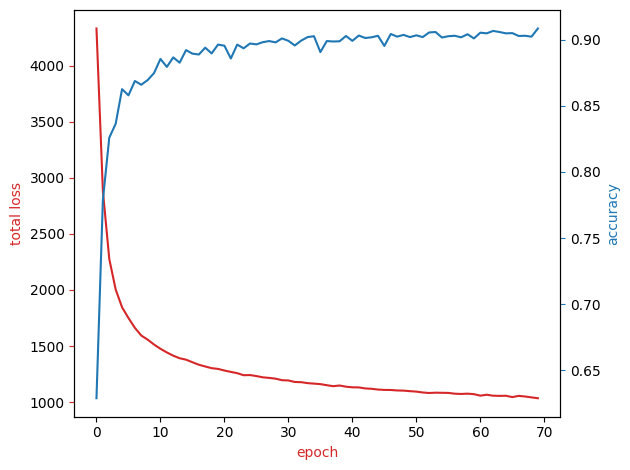

In [35]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bQk8mJu3Uct3I4JEsEtRnw/model-AG%20News%20small1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KNQkqJWWwY_XfbFBRFhZNA/model-AG%20News%20small1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following code loads the pretrained model and evaluates its performance on the AG News test set. **For efficiency, let's not run the evaluation because it can take a few minutes. Instead, claim that the pretrained model works well on the AG News dataset. If you would like to confirm the result for yourself, feel free to uncomment the last line in the following code block.**


In [36]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_ag_news_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_ag_news_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader_ag_news, model_ag_news_)

<All keys matched successfully>

As you can see, the pretrained model worked extremely well on the AG News data set. However, can this model be fine-tuned to perform well on the IMDB data set as well? Let's find out! You can begin by loading the pretrained AG News model.


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine1 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine1.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))


The IMDB dataset is a binary classification task with only two classes (positive and negative reviews). Therefore, the output layer of the AG NEWS model should be adjusted to have just two output neurons to reflect the binary nature of the IMDB dataset. This adjustment is essential for the model to accurately learn and predict the sentiment of movie reviews in the IMDB dataset.


In [ ]:
model_fine1.classifier
in_features = model_fine1.classifier.in_features
print("Original final layer:", model_fine1.classifier)
print("Input dimention  final layer:", in_features)

You can change the final layer into a two-class problem.


In [ ]:
model_fine1.classifier = nn.Linear(in_features, 2)
model_fine1.to(device)

The following code shows the layers that are frozen (`requires_grad == False`) and unfrozen (`requires_grad == True`) in the model. The unfrozen layers will have their weights updated during fine-tuning.


In [ ]:
for name, param in model_fine1.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

The following code block simulates fine-tuning on the shortened training set for just 2 epochs. **For the sake of time efficiency, this code block has been commented out**. If you want to see what training looks like, uncomment the following code block, but remember that this code could take approximately 2 minutes to run.


In [ ]:
'''
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine1.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine1.pth"
train_model(model=model_fine1, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )
'''

The following code shows the progress of full fine-tuning of the entire IMDB training set for 100 epochs.


In [ ]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/3LEJw8BRgJJFGqlLxaETxA/model-fine1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/-CT1h97vjv0TolY82Nw29g/model-fine1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following line loads a prefine-tuned model that was trained for 100 epochs on the full IMDB training set and evaluates its performance on the IMDB test set. **For the sake of efficiency, let's not run the evaluation because it can take a few minutes to run. Instead, report the result underneath the cell. If you would like to confirm the result for yourself, feel free to uncomment the last line in the code block.**


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/e0WOHKh5dnrbC2lGhpsMMw/model-fine1.pth')
model_fine1_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine1_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader, model_fine1_)

This model demonstrated notable improvement, exhibiting a remarkable achievement with an accuracy of 86% on the test data. This is higher than the 83% achieved by the model trained from scratch on the IMDB dataset. Although the training process was time-intensive (The fine-tuning was as time-intensive as training the model from scratch), the enhanced performance underscores the fine-tuned model's effectiveness and superiority over the model trained from scratch. Much of the computational effort was devoted to updating the transformer layers. To expedite the training process, one viable strategy is to focus on training the final layer only, which can significantly reduce the computational load but might compromise the model's accuracy.


### Fine-tune the final layer only

Fine-tuning the final output layer of a neural network is similar to fine-tuning the whole model. You can begin by loading the pretrained model that you would like to fine-tune. In this case, it is the same model pretrained on the AG News data set.


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine2 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine2.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

Now, the key difference. You iterate through all of the parameters in the `model_fine2` model and set the `requires_grad` attribute of each parameter to `False`. This effectively freezes all of the layers in the model, meaning that their weights are to be updated during training.


In [ ]:
# Freeze all layers in the model
for param in model_fine2.parameters():
    param.requires_grad = False

Replace the final layer to reflect the fact that you are solving a two-class problem. Note that the new layer will be unfrozen.


In [ ]:
dim=model_fine2.classifier.in_features

In [ ]:
model_fine2.classifier = nn.Linear(dim, 2)

In [ ]:
model_fine2.to(device)


The following block simulates fine-tuning on the shortened training set for just 2 epochs. **For the sake of time efficiency, this code block has been commented out**. The following code should take a shorter amount of time to train than the full fine-tuning conducted previously because only the final layer is unfrozen.


In [ ]:
'''
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine2.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine2.pth"
train_model(model=model_fine2, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )
'''

Once again, you will not use the model that you just fine-tuned, but instead inspect the final layer fine-tuning process of a model fine-tuned on the full IMDB training set for 100 epochs.


In [ ]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UdR3ApQnxSeV2mrA0CbiLg/model-fine2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rWGDIF-uL2dEngWcIo9teQ/model-fine2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following line loads the pretrained model and evaluates its performance on the test set. **For efficiency, let's not run the evaluation because it can take a few minutes to run. Instead, report the result underneath the cell. If you would like to confirm the result for yourself, feel free to uncomment the last line in the following code block.**


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/B-1H6lpDg-A0zRwpB6Ek2g/model-fine2.pth')
model_fine2_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine2_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader, model_fine2_)

The previous code indicates that although fine-tuning the final layer takes a significantly smaller amount of time than fine-tuning the whole model, the performance of the model with just the last layer unfrozen is significantly worse (64% accuracy) than the fine-tuned model with all layers unfrozen (86% accuracy).


---


# Adapters
FeatureAdapter is a neural network module that introduces a low-dimensional bottleneck in a transformer architecture to allow fine-tuning with fewer parameters. It compresses the original high-dimensional embeddings into a lower dimension, applies a non-linear transformation, and then expands it back to the original dimension. This process is followed by a residual
connection that adds the transformed output back to the original input to preserve information and
promote gradient flow.

## Benefits of using adapters in neural networks

- **Efficient fine-tuning**: Adapters allow for targeted updates to specific parts of the model, reducing the need to retrain large sections of the network.

- **Parameter efficiency**: By adding only a few parameters, adapters make it feasible to modify large models without substantial computational overhead.

- **Preservation of pretrained features**: Adapters enable the modification of a model while retaining the valuable features learned during extensive pretraining.

- **Modularity and flexibility**: They enhance the modularity of models, allowing easy adaptation to various tasks without altering core architecture.

- **Task-specific adaptation**: Adapters can be tailored to improve performance on particular tasks, optimizing the model’s effectiveness.

- **Transfer learning and domain adaptation**: They facilitate the adaptation of models to new domains, bridging gaps between different data distributions.

- **Continual learning**: Adapters support the model's ability to learn new information continuously without forgetting previous knowledge.

- **Reduced risk of overfitting**: With fewer trainable parameters, adapters help prevent overfitting, especially on smaller data sets.

The following code shows an adapter model.


In [ ]:
class FeatureAdapter(nn.Module):
    """
    Attributes:
        size (int): The bottleneck dimension to which the embeddings are temporarily reduced.
        model_dim (int): The original dimension of the embeddings or features in the transformer model.
    """
    def __init__(self, bottleneck_size=50, model_dim=100):
        super().__init__()
        self.bottleneck_transform = nn.Sequential(
            nn.Linear(model_dim, bottleneck_size),  # Down-project to a smaller dimension
            nn.ReLU(),                             # Apply non-linearity
            nn.Linear(bottleneck_size, model_dim)  # Up-project back to the original dimension
        )

    def forward(self, x):
        """
        Forward pass of the FeatureAdapter. Applies the bottleneck transformation to the input
        tensor and adds a skip connection.

        Args:
            x (Tensor): Input tensor with shape (batch_size, seq_length, model_dim).

        Returns:
            Tensor: Output tensor after applying the adapter transformation and skip connection,
                    maintaining the original input shape.
        """
        transformed_features = self.bottleneck_transform(x)  # Transform features through the bottleneck
        output_with_residual = transformed_features + x      # Add the residual connection
        return output_with_residual

The adapted class wraps this adapter functionality around any specified linear layer, enhancing its output with the non-linearity of a ReLU activation function. This setup is particularly useful for experimenting with subtle architectural modifications in deep learning models, facilitating fine-tuning and potentially improving model performance on complex tasks.


In [ ]:
class Adapted(nn.Module):
    def __init__(self, linear,bottleneck_size=None):
        super(Adapted, self).__init__()
        self.linear = linear
        model_dim = linear.out_features
        if bottleneck_size is None:
          bottleneck_size = model_dim//2   # Define default bottleneck size as half the model_dim

        # Initialize FeatureAdapter with calculated bottleneck_size and model_dim
        self.adaptor = FeatureAdapter(bottleneck_size=bottleneck_size, model_dim=model_dim)

    def forward(self, x):
        # First, the input x is passed through the linear layer
        x=self.linear(x)
        # Then it's adapted using FeatureAdapter
        x= self.adaptor(x)
        return x

You load the pretrained transformer model that was trained on the AG News dataset.


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_adapters = Net(vocab_size=vocab_size, num_class=4).to(device)
model_adapters.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))


First, freeze the parameters of a model named model_adapters to prevent them from being updated during training. Then, retrieve the number of input features for the classifier, and replace the classifier with a new linear layer that outputs to two classes.


In [ ]:
for param in model_adapters.parameters():
    param.requires_grad = False

dim= model_adapters.classifier.in_features
model_adapters.classifier = nn.Linear(dim, 2)

Let's explore how to apply the adapted object to a linear layer to obtain the first output. You can obtain the unadapted linear layer for the first output by:


In [ ]:
my_example_layer=model_adapters.transformer_encoder.layers[0].linear1
print(my_example_layer)

In the following code, you copy the linear layer and add an adapter layer to it.


In [ ]:
my_adapeted_layer=Adapted(my_example_layer)
print(my_adapeted_layer)

You can print the adapted layer and show that the new layers have their requires_grad attribute set to True, indicating that these layers will be updated during training.


In [ ]:
for parm in my_adapeted_layer.parameters():
    print(parm.requires_grad)

You can set a layer in the model to the adapter layer, as shown in the following code in the commented-out line. However, because there are many layers, a more systematic approach would be to traverse the model and replace specific layers with the adapter layer. Note that you should set the bottleneck size to 24, ensuring that there are fewer parameters to train than during a full fine-tuning.


In [ ]:
# Adapt a specific layer
#model_adapters.transformer_encoder.layers[0].linear1=Adapted(my_example_layer)

In [ ]:
# Find number of layers
N_layers=len(model_adapters.transformer_encoder.layers)

In [ ]:
# Traverse model and adapt
for n in range(N_layers):
  encoder=model_adapters.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)
    model_adapters.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)

The following code sends the model to the device.


In [ ]:
# Send model to device
model_adapters.to(device)

Finally, the following code simulates training of the adapted model by training on a shortend IMDB train set for 2 epochs.


In [ ]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_adapters.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_adapters.pth"
train_model(model=model_adapters, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

Naturally, you will not use the model you just trained. Instead, you will track the training of an adapted model fine-tuned on the full IMDB dataset for 100 epochs.


In [ ]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/D49zrrMPWO_ktwQo7PSHIQ/model-adapters-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RXWlmyaco695RiaoU7QsnA/model-adapters-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following code loads the adapted model fine-tuned for 100 epochs on the full IMDB train set and evaluates its performance on the IMDB test set.


In [ ]:
model_adapters_ = Net(vocab_size=vocab_size, num_class=2).to(device)
for n in range(N_layers):
  encoder=model_adapters_.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters_.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters_.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters_.transformer_encoder.layers[n].linear2)
    model_adapters_.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters_.transformer_encoder.layers[n].linear2)

model_adapters_.to(device)
for param in model_adapters_.parameters():
    param.requires_grad = False

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/PGhd5G_NVrWNH-_jdjwNlw/model-adapters.pth')
model_adapters_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_adapters_)

As you can see, the performance of the fine-tuned adapted model is nearly identical to the fully fine-tuned model, with both models achieving a roughly 86% accuracy. This is an especially surprising result because a significantly smaller number of weights were updated for the adapted model than the fully fine-tuned model. Note that only the adapter layers with a bottleneck size of 24 and the final classifier layer are unfrozen.


The above shows that adapters can be used for parameter efficient fine-tuning (PEFT) and that the performance of a model fine-tuned using adapters can be almost as good as a fully fine-tuned model with all of the layers unfrozen!


---


## Exercise: Adapt linear layers in a different network

The following code defines a neural network called `NeuralNetwork`.


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

exercise_model = NeuralNetwork()

exercise_model.to(device)
for param in exercise_model.parameters():
    param.requires_grad = False

print(exercise_model)

`NeuralNetwork` is a neural network that uses the `Sequential` container from PyTorch. Adapt the first two linear layers in the `Sequential` container by using the bottleneck adapter with a bottleneck size of 30. Also, change the last linear layer to a layer that has 5 outputs.


In [ ]:
### REPLACE THIS YOUR ANSWER ###


<details>
    <summary>Click here for the solution</summary>

```python
exercise_model.linear_relu_stack[0] = Adapted(exercise_model.linear_relu_stack[0], bottleneck_size=30)
exercise_model.linear_relu_stack[2] = Adapted(exercise_model.linear_relu_stack[2], bottleneck_size=30)
exercise_model.linear_relu_stack[4] = nn.Linear(512, 5)
print(exercise_model)
```

</details>


---


## Congratulations! You have completed the lab


## Authors


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo)

Joseph has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk) 

Wojciech "Victor" Fulmyk is a Data Scientist at IBM, and a PhD Candidate in economics at the University of Calgary.


[Ashutosh Sagar](https://www.linkedin.com/in/ashutoshsagar/) is completing his MS in CS from Dalhousie University. He has previous experience working with Natural Language Processing and as a Data Scientist.


## References


[TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

[Parameter-Efficient Transfer Learning for NLP](https://arxiv.org/pdf/1902.00751.pdf)

[Simple, Scalable Adaptation for Neural Machine Translation](https://arxiv.org/pdf/1909.08478)


© Copyright IBM Corporation. All rights reserved.
